Pada notebook sebelumnya telah dilakukan proses rekayasa fitur atau *feature engineering*. Pada notebook ini saya akan mendemonstrasikan proses pemodelan machine learning-nya. Dengan cara yang serupa pada notebook sebelumnya, saya membentuk berkas CSV yang memuat informasi mengenai elemen Matriks Coulomb dan energi atomisasi dari molekul-molekul tertentu. Molekul-molekul tersebut memenuhi beberapa kriteria sebagai berikut.
- Molekul terdiri dari unsur C, H, N, O, P, S.
- Setiap molekul paling sedikit memiliki 2 atom dan paling banyak 50 atom.
- Jarak maksimum antara 2 atom pada molekul tidak lebih dari $25a_0$, dengan $a_0$ adalah jari-jari Bohr.

Apabila syarat-syarat diatas diterapkan pada database PubChem, dihasilkan 16242 molekul pada berkas CSV.

In [ ]:
!wget --no-check-certificate \
    https://simpan.ugm.ac.id/s/mXmKQxTXyyrzRJr/download \
    -O /tmp/energy-molecule.zip

!wget --no-check-certificate \
    https://simpan.ugm.ac.id/s/KEp0BrgNystnmmA/download \
    -O /tmp/coulombL.csv

--2020-11-25 17:30:17--  https://simpan.ugm.ac.id/s/mXmKQxTXyyrzRJr/download
Resolving simpan.ugm.ac.id (simpan.ugm.ac.id)... 175.111.88.197
Connecting to simpan.ugm.ac.id (simpan.ugm.ac.id)|175.111.88.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52083703 (50M) [application/zip]
Saving to: ‘/tmp/energy-molecule.zip’

/tmp/energy-molecul 100%[===================>]  49.67M  7.21MB/s    in 2m 9s   

2020-11-25 17:32:29 (393 KB/s) - ‘/tmp/energy-molecule.zip’ saved [52083703/52083703]

--2020-11-25 17:32:29--  https://simpan.ugm.ac.id/s/KEp0BrgNystnmmA/download
Resolving simpan.ugm.ac.id (simpan.ugm.ac.id)... 175.111.88.197
Connecting to simpan.ugm.ac.id (simpan.ugm.ac.id)|175.111.88.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7756187 (7.4M) [text/csv]
Saving to: ‘/tmp/coulombL.csv’

/tmp/coulombL.csv   100%[===================>]   7.40M  1.44MB/s    in 5.4s    

2020-11-25 17:32:36 (1.38 MB/s) - ‘/tmp/coulombL.csv’ saved [

In [ ]:
import zipfile, os
local_zip = '/tmp/energy-molecule.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/energy-molecule')
zip_ref.close()
base_dir = '/tmp/energy-molecule/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, make_scorer
from sklearn.decomposition import PCA
import time
sns.set()

In [ ]:
df = pd.read_csv('/tmp/energy-molecule/roboBohr.csv')
coulombl = pd.read_csv('/tmp/coulombL.csv', header=None, index_col=0)

# Pra-pemrosesan dan analisis data eksploratif

Sebelum melakukan pemodelan, saya akan melakukan pra-pemrosesan data untuk memastikan bahwa data benar-benar siap untuk dimasukkan ke model. Selain itu juga saya akan melakukan eksplorasi terhadap data untuk memberikan pemahaman lebih mengenai data hingga menemukan *insight* baru dari data.

In [ ]:
df.shape

(16242, 1278)

In [ ]:
df.columns.values

array(['Unnamed: 0', '0', '1', ..., '1274', 'pubchem_id', 'Eat'],
      dtype=object)

In [ ]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,12.342823,12.335925,12.328055,12.284265,12.269844,12.247357,10.557967,10.473721,9.225262,8.448526,7.611145,7.610874,7.580510,7.579386,7.576929,7.536001,7.517317,7.462578,7.459865,7.456214,7.447581,7.443458,7.423496,7.345785,7.323741,7.247088,7.230886,6.662523,6.286251,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,15.202985,14.800045,12.855629,12.728858,12.618058,12.589962,12.557323,12.074893,10.607138,10.572061,10.464293,9.816674,9.456914,9.455816,8.865704,8.104048,8.006855,7.968817,7.946644,7.932943,7.922656,7.888724,7.885692,7.783220,7.637477,7.636586,7.631457,7.336591,7.127698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,7.607776,7.550253,7.446675,7.398848,7.381532,7.355045,7.321944,6.625986,6.116315,6.106397,6.098066,5.989868,5.731750,5.700963,5.371527,5.008911,4.894453,4.826545,4.352232,4.270598,2.902330,2.902220,2.901834,2.901089,2.900168,2.900151,2.899983,2.898772,2.898551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,12.420665,12.410312,12.346845,12.175480,12.098758,10.612802,10.610273,10.606738,10.606702,10.433290,8.694957,8.421582,8.103569,8.103345,7.595619,7.566897,7.555411,7.413109,7.403199,7.185256,6.915425,6.198245,6.191266,6.181797,6.152544,5.252689,5.244354,5.176740,5.176314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,10.485270,8.595823,8.103880,8.103567,7.975189,7.546413,7.503300,6.803380,6.738768,5.169492,5.161869,5.145972,4.924911,4.899245,4.534996,4.486310,3.897466,3.081523,2.957823,2.903069,2.902178,2.900610,2.900542,2.900306,2.899368,2.899113,2.897739,2.896793,2.896063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


DataFrame terdiri dari 16242 baris yang menunjukkan jumlah molekul dan 1278 kolom dengan rincian sebagai berikut.
- **Unnamed: 0**: indeks.
- **0 - 1274**: 1275 fitur yang merupakan elemen segitiga atas Matriks Coulomb (**variabel predictor**).
- **pubchem_id**: nomor identitas molekul pada PubChem.
- **Eat**: energi atomisasi molekul (**variabel yang akan diprediksi**).

Karena **Unnamed: 0** hanya merupakan indeks untuk setiap molekul pada DataFrame dan **pubchem_id** hanya merupakan nomor identitas pada database PubChem, maka kolom tersebut perlu saya hilangkan (*drop*) karena secara intuitif tidak berperan apa-apa dalam pemodelan bahkan berpotensi mempengaruhi model yang akan dibuat (dapat menimbulkan *bias*).

In [ ]:
df = df.drop(['Unnamed: 0', 'pubchem_id'], axis=1)

In [ ]:
df.isnull().sum().sum()

0

Berikut adalah bentuk DataFrame saat ini.

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,12.342823,12.335925,12.328055,12.284265,12.269844,12.247357,10.557967,10.473721,9.225262,8.448526,7.611145,7.610874,7.580510,7.579386,7.576929,7.536001,7.517317,7.462578,7.459865,7.456214,7.447581,7.443458,7.423496,7.345785,7.323741,7.247088,7.230886,6.662523,6.286251,6.134338,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,15.202985,14.800045,12.855629,12.728858,12.618058,12.589962,12.557323,12.074893,10.607138,10.572061,10.464293,9.816674,9.456914,9.455816,8.865704,8.104048,8.006855,7.968817,7.946644,7.932943,7.922656,7.888724,7.885692,7.783220,7.637477,7.636586,7.631457,7.336591,7.127698,6.974135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,7.607776,7.550253,7.446675,7.398848,7.381532,7.355045,7.321944,6.625986,6.116315,6.106397,6.098066,5.989868,5.731750,5.700963,5.371527,5.008911,4.894453,4.826545,4.352232,4.270598,2.902330,2.902220,2.901834,2.901089,2.900168,2.900151,2.899983,2.898772,2.898551,2.897620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,12.420665,12.410312,12.346845,12.175480,12.098758,10.612802,10.610273,10.606738,10.606702,10.433290,8.694957,8.421582,8.103569,8.103345,7.595619,7.566897,7.555411,7.413109,7.403199,7.185256,6.915425,6.198245,6.191266,6.181797,6.152544,5.252689,5.244354,5.176740,5.176314,5.175577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,10.485270,8.595823,8.103880,8.103567,7.975189,7.546413,7.503300,6.803380,6.738768,5.169492,5.161869,5.145972,4.924911,4.899245,4.534996,4.486310,3.897466,3.081523,2.957823,2.903069,2.902178,2.900610,2.900542,2.900306,2.899368,2.899113,2.897739,2.896793,2.896063,2.895051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.537140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,73.516695,20.753166,18.624076,17.872009,17.851690,17.851254,17.742176,14.655754,12.706683,12.557785,12.557113,10.855517,10.612536,10.606837,10.606647,10.575946,10.546340,9.328498,9.319485,9.295251,8.103619,8.059486,6.733081,6.025705,5.353745,5.345835,5.343937,5.200625,5.190235,5.176243,5.175604,4.741453,4.352078,4.247954,4.224297,4.218675,4.030840,3.982557,3.980375,3.910149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.876123
16238,73.516695,20.724740,18.579933,17.741621,14.716676,13.6978

Selanjutnya saya akan mengeksplorasi distribusi nilai energi atomisasi molekul yang ada pada DataFrame.

In [ ]:
df['Eat'].describe()

count    16242.000000
mean       -11.178969
std          3.659133
min        -23.245373
25%        -13.475805
50%        -10.835211
75%         -8.623903
max         -0.789513
Name: Eat, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribusi Energi Atomisasi')

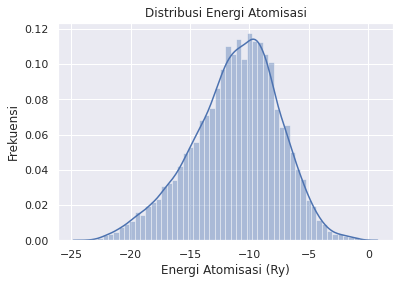

In [ ]:
sns.distplot(df['Eat'], kde=True)
plt.xlabel('Energi Atomisasi (Ry)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Energi Atomisasi')

# Visualisasi Principal Component Analysis (PCA)

**Dimensionality Reduction** atau pengurangan dimensi adalah upaya untuk mengurangi atribut pada dataset yang digunakan dalam pemodelan machine learning tanpa mengurangi informasi yang ada. Harapannya, dengan dimensionality reduction dapat mempercepat proses pelatihan model ML secara signifikan.

Terdapat beberapa teknik dalam pengurangan dimensi, salah satu yang populer digunakan adalah **Principal Component Analysis (PCA)**. PCA bekerja dengan menghitung variance dari tiap atribut. **Variance** adalah informasi yang dimiliki sebuah atribut. Sehingga apabila ditemukan atribut yang memiliki variance kecil dapat dihilangkan karena pengaruhnya tidak signifikan terhadap akurasi namun dapat mempercepat proses training secara signifikan.

In [ ]:
pca = PCA(n_components=2)
z = pca.fit_transform(coulombl)
z = pd.DataFrame(z)

Text(0.5, 1.0, 'Energi Atomisasi sebagai fungsi dua komponen PCA (z1, z2)')

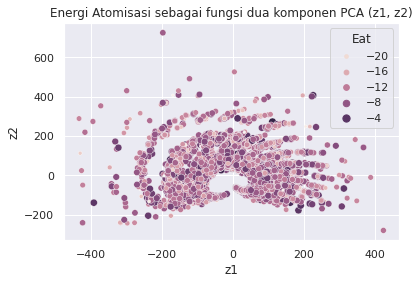

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.scatterplot(x=-z[0], y=z[1],
                     size=df['Eat'], hue=df['Eat'],
                     palette=cmap, sizes=(5, 60))
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Energi Atomisasi sebagai fungsi dua komponen PCA (z1, z2)')

In [ ]:
# z.rename(columns={0:'pca_0', 1:'pca_1'}, inplace=True)
# df = pd.concat([df, z], axis=1, sort=False)

# Pemodelan Machine Learning

Saya akan membuat dua model machine learning, yaitu:
- Boosted Regression Tree dengan XGBoost dari scikit-learn.
- Neural Network (jaringan saraf tiruan) dari TensorFlow dan Keras.

Kali ini saya menggunakan **RMSE** dan **MAE** sebagai metrics evaluasi. Sebelumnya saya hanya menggunakan RMSE saja, namun setelah mempelajari kembali, MAE lebih mudah diinterpretasikan makna fisisnya dibanding RMSE. Sehingga saya akan menggunakan keduanya kali ini. Berikut adalah definisi masing-masing metrics.

$$ MAE = \frac{1}{n} \sum^n_{j=1} |y_j - \hat{y}_j| $$

$$ RMSE = \sqrt{\frac{1}{n} \sum^n_{j=1} (y_j - \hat{y}_j)^2} $$

dengan $y_j$ adalah nilai sesungguhnya dan $\hat{y}_j$ adalah nilai prediksi.

Pertama-tama saya akan memisahkan DataFrame menjadi **X** dan **Y**, dimana X memuat elemen Matriks Coulomb dan Y memuat energi atomisasi molekul.

In [ ]:
X = df.drop(['Eat'], axis=1)
Y = df['Eat']

X = X.values
Y = Y.values

Selanjutnya dengan menggunakan `train_test_split` dari scikit-learn, saya akan membuat **data latih** dan **data uji**. Data latih atau data training akan digunakan untuk melatih model sedangkan data uji sengaja dipisahkan dari awal agar selama proses pelatihan model belum pernah mengenali data uji tersebut. Sehingga kita dapat mengukur seberapa akurat model yang dibuat dalam memprediksi data yang belum pernah dikenali sama sekali. Saya akan mengambil 30% dari data sebagai data uji.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

## Model Boosted Regression Tree

Model Boosted Regression Tree adalah model yang lebih sederhana dibanding Neural Network, sehingga cost komputasi yang dibutuhkan sebenarnya lebih rendah. Berikut adalah proses pembuatan arsitektur model Boosted Regression Tree.

In [ ]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.0625,
    reg_lambda=0,
    max_depth=6,
    colsample_bytree=0.2,
    min_child_weight=10,
    n_estimators=400)

Pada model XGBoost, saya akan menggunakan metode **cross validation** dalam melakukan evaluasi model. Namun pada model Neural Network, saya akan menggunakan metode **hold-out validation** dalam melakukan evaluasi model. Hal ini dikarenakan evaluasi dengan cross validation membutuhkan cost komputasi yang cukup besar, sehingga apabila diterapkan pada model Neural Network yang dari awal sudah membutuhkan cost yang lumayan besar, tentu mengakibatkan proses evaluasi akan sangat lama (membutuhkan cost yang semakin besar). Cross validation dapat mencegah model yang dibuat mengalami **overfitting**.

In [ ]:
def rmse_fun(predicted, actual):
  return np.sqrt(np.mean(np.square(predicted - actual)))

In [ ]:
start_time = time.time()

rmse = make_scorer(rmse_fun, greater_is_better=False)
xgb_scores = -1.0 * cross_val_score(xgb, x_train, y_train, scoring=rmse, cv=5).mean()
print(xgb_scores)

print("--- %s seconds ---" % (time.time() - start_time))

0.09249213918540175
--- 352.1634967327118 seconds ---


Hasil diatas adalah rata-rata RMSE dari setiap fold yang merupakan hasil evaluasi cross validation dari model XGBoost. Selanjutnya model akan melakukan proses training.

In [ ]:
start_time = time.time()
xgb.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 87.55596566200256 seconds ---


Model telah selesai melakukan pelatihan. Selanjutnya model akan memprediksi nilai energi atomisasi pada data uji untuk mengukur akurasinya pada data yang belum pernah dilihat sama sekali.

In [ ]:
start_time = time.time()
y_pred_xgb = xgb.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1775951385498047 seconds ---


In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('Accuracy:', xgb.score(x_test, y_test))

RMSE: 0.08572747294317806
MAE: 0.05322593264668544
Accuracy: 0.9994420924584964


Berdasarkan hasil diatas, model XGBoost memiliki akurasi hingga 99% dengan ralat (MAE) sebesar 0.06, artinya rata-rata dari selisih nilai prediksi dengan nilai sesungguhnya sebesar 0.06.

Terdapat beberapa cara (selain berdasarkan metrics evaluasi diatas) untuk melihat seberapa akurat model dalam memprediksi. Diantaranya adalah:
- Membandingkan rata-rata energi atomisasi yang diprediksi model dengan nilai sebenarnya pada data uji.
- Membandingkan energi atomisasi yang diprediksi model dengan nilai sebenarnya pada data uji dengan visualisasi.

In [ ]:
print(pd.DataFrame({'Sumber':['Data uji', 'Hasil prediksi'], 'Rata-rata E':[y_pred_xgb.mean(), y_test.mean()]}))

           Sumber  Rata-rata E
0        Data uji   -11.093675
1  Hasil prediksi   -11.097423


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


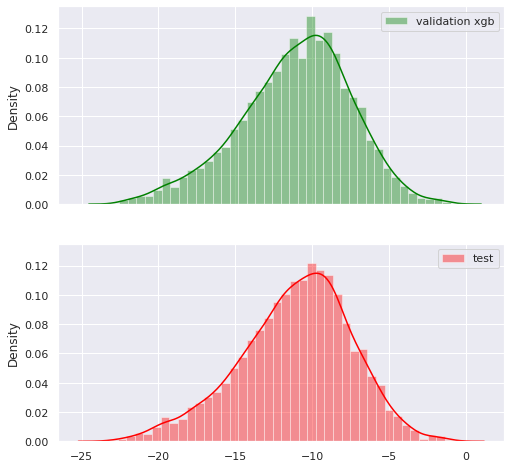

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 8))
sns.distplot(y_pred_xgb, ax=ax[0], color='green', label='validation xgb')
sns.distplot(y_test, ax=ax[1], color='red', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

## Model Neural Network

Model Neural Network (jaringan saraf tiruan) merupakan bentuk model yang lebih rumit, sehingga secara umum cost komputasi yang dibutuhkan lebih besar. Dengan demikian secara umum model neural network biasanya memiliki akurasi yang lebih tinggi. Dalam membangun arsitektur neural network, saya menggunakan library TensorFlow dan Keras.

Untuk mencegah overfitting pada model Neural Network, saya akan menerapkan **Callbacks**. Callbacks dapat menghentikan proses training secara otomatis apabila telah memenuhi persyaratan yang kita atur. Dalam hal ini, saya akan menghentikan proses training apabila: $MAE \leq 2\%$ skala data. Skala data saya definisikan sebagai: $E_{max} - E_{min}$. Sehingga nantinya proses training akan berhenti apabila rata-rata selisih nilai prediksi dengan nilai sesungguhnya (ralat) kurang dari atau sama dengan 2% dari skala data.

In [ ]:
skala_data = max(df['Eat']) - min(df['Eat'])
skala_data

22.455859259999897

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') <= 0.02 * skala_data and logs.get('val_mae') <= 0.02 * skala_data):
          print('\nmae dan val_mae telah kurang dari sama dengan 2% skala data.')
          self.model.stop_training = True
callbacks = myCallback()

Berikutnya saya akan membangun arsitektur neural network dengan **3 hidden layer** dan juga menerapkan **dropout** untuk mencegah overfitting.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

Kita juga dapat melihat arsitektur yang kita lihat sekaligus "perjalanan" input pada setiap layer dengan `model.summary()`.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1306624   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6

In [ ]:
model.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae', 'mse'])

Selanjutnya akan dilakukan proses training model neural network.

In [ ]:
start_time = time.time()

EPOCHS = 100
history = model.fit(x_train, y_train,
                    epochs=EPOCHS, validation_data=(x_test, y_test), verbose=1, callbacks=[callbacks])

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
356/356 [==============================] - 8s 21ms/step - loss: 24.8793 - mae: 2.3694 - mse: 24.8793 - val_loss: 2.1634 - val_mae: 0.9215 - val_mse: 2.1634
Epoch 2/100
356/356 [==============================] - 7s 21ms/step - loss: 3.0901 - mae: 1.3155 - mse: 3.0901 - val_loss: 1.6231 - val_mae: 0.7180 - val_mse: 1.6231
Epoch 3/100
356/356 [==============================] - 7s 21ms/step - loss: 2.4294 - mae: 1.1559 - mse: 2.4294 - val_loss: 0.8981 - val_mae: 0.5597 - val_mse: 0.8981
Epoch 4/100
356/356 [==============================] - 7s 21ms/step - loss: 1.8063 - mae: 1.0150 - mse: 1.8063 - val_loss: 1.2648 - val_mae: 0.8742 - val_mse: 1.2648
Epoch 5/100
356/356 [==============================] - 8s 21ms/step - loss: 1.4439 - mae: 0.9110 - mse: 1.4439 - val_loss: 0.5991 - val_mae: 0.5285 - val_mse: 0.5991
Epoch 6/100
356/356 [==============================] - 8s 23ms/step - loss: 1.3667 - mae: 0.8755 - mse: 1.3667 - val_loss: 0.6612 - val_mae: 0.5703 - val_mse: 0.6612
Ep

Proses pelatihan berhenti diantara epoch ke-25 hingga ke-30 karena telah memenuhi persyaratan pada Callbacks. Dari hasil diatas didapatkan bahwa pada model neural network, MAE pada data training sebesar 0.4434, sedangkan MAE pada data uji (ditunjukkan oleh besaran val_mae) sebesar 0.3559. Berikut saya melakukan plot terhadap proses training yang dilakukan.

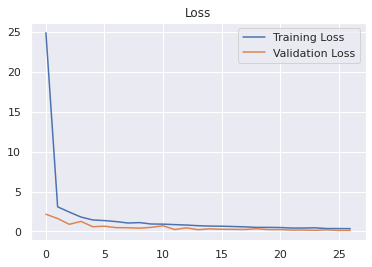

In [ ]:
plt_loss = [history.history['loss'],history.history['val_loss']]
plt.plot(range(len(plt_loss[0])), plt_loss[0], label='Training Loss')
plt.plot(range(len(plt_loss[1])), plt_loss[1], label='Validation Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()
plt.show()

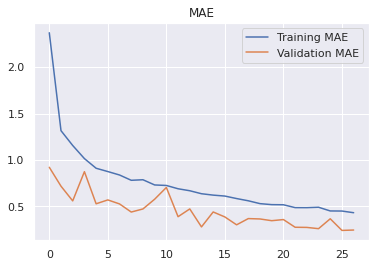

In [ ]:
plt_mae = [history.history['mae'],history.history['val_mae']]
plt.plot(range(len(plt_mae[0])), plt_mae[0], label='Training MAE')
plt.plot(range(len(plt_mae[1])), plt_mae[1], label='Validation MAE')
plt.title('MAE')
plt.grid(True)
plt.legend()
plt.show()

Untuk mengukur akurasi model, selain dengan melihat metrics evaluasi secara langsung seperti diatas, dapat juga dilakukan dengan membandingkan nilai beberapa sampel nilai prediksi dengan nilai sesungguhnya serta melakukan visualisasi pada data uji.

In [ ]:
seq_prd = model.predict(x_test[:5])
print(seq_prd)

[[-13.899738 ]
 [ -7.7367063]
 [ -7.828145 ]
 [-17.880522 ]
 [ -9.201481 ]]


In [ ]:
print(y_test[:5])

[-13.69200944  -7.6988692   -7.69813553 -17.29433679  -9.19994224]


In [ ]:
start_time = time.time()

y_pred_seq = model.predict(x_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7676088809967041 seconds ---


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


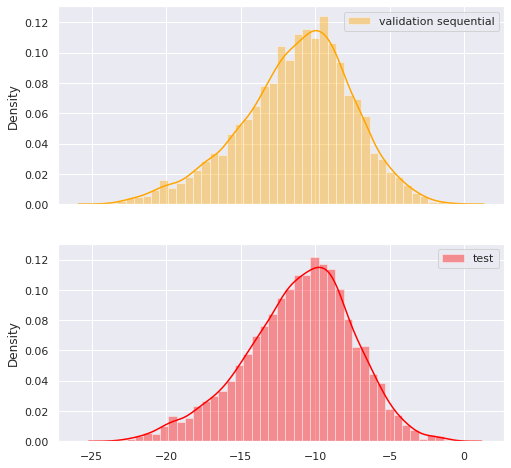

In [ ]:
fig1, ax1 = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,8))
sns.distplot(y_pred_seq, ax=ax1[0], color='orange', label='validation sequential')
sns.distplot(y_test, ax=ax1[1], color='red', label='test')
ax1[0].legend(loc=0)
ax1[1].legend(loc=0)
plt.show()

# Kesimpulan

Demikian demonstrasi proses pemodelan machine learning untuk memprediksi energi atomisasi molekul berdasarkan fitur elemen Matriks Coulomb dengan algoritma Boosted Regression Tree (XGBoost) dan Neural Network. Dari simulasi diatas, didapatkan bahwa model XGBoost memiliki akurasi yang lebih tinggi dan cost komputasinya lebih rendah. Kedua model juga telah divalidasi baik dengan cross validation 5-fold maupun hold-out validation. Pada simulasi ini, metrics evaluasi yang digunakan adalah MAE dan RMSE yang keduanya merupakan besaran yang menunjukkan ralat dari model (semakin kecil artinya semakin akurat). Berikut ringkasan hasil dari simulasi yang telah dilakukan.

In [ ]:
print(pd.DataFrame({'Model':['XGB', 'Neural Network'],
                    'MAE':[mean_absolute_error(y_test, y_pred_xgb), mean_absolute_error(y_test, y_pred_seq)],
                    'RMSE':[np.sqrt(mean_squared_error(y_test, y_pred_xgb)), np.sqrt(mean_squared_error(y_test, y_pred_seq))]}))

            Model       MAE      RMSE
0             XGB  0.053226  0.085727
1  Neural Network  0.246064  0.367889


In [ ]:
print(pd.DataFrame({'Model':['XGB', 'Neural Network', 'Data uji'],
                    'Rata-rata E':[y_pred_xgb.mean(), y_pred_seq.mean(), y_test.mean()]
                    }))

            Model  Rata-rata E
0             XGB   -11.093675
1  Neural Network   -11.254704
2        Data uji   -11.097423


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

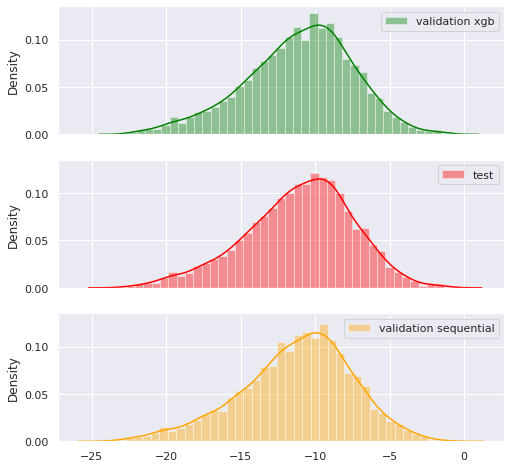

In [ ]:
fig2, ax2 = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8,8))
sns.distplot(y_pred_xgb, ax=ax2[0], color='green', label='validation xgb')
sns.distplot(y_pred_seq, ax=ax2[2], color='orange', label='validation sequential')
sns.distplot(y_test, ax=ax2[1], color='red', label='test')
ax2[0].legend(loc=0)
ax2[1].legend(loc=0)
ax2[2].legend(loc=0)
plt.show()

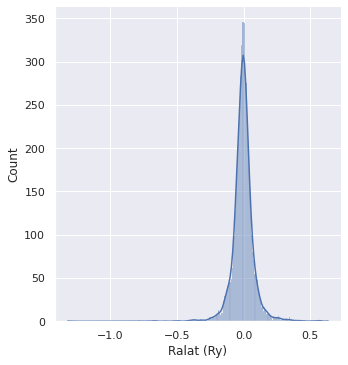

In [ ]:
g = sns.displot(y_test - y_pred_xgb, kde=True)
g.set_axis_labels('Ralat (Ry)')

In [ ]:
print('Hello')

Hello


In [ ]:
a = y_test - y_pred_xgb
a.shape

(4873,)

In [ ]:
b = y_test - y_pred_seq
b.shape

(4873, 4873)

In [ ]:
y_test

array([-13.69200944,  -7.6988692 ,  -7.69813553, ..., -16.33602571,
       -11.98814157,  -6.88613402])

In [ ]:
y_pred_seq.shape

(4873, 1)

In [ ]:
y_pred_xgb

array([-13.770584 ,  -7.634658 ,  -7.6486473, ..., -16.388105 ,
       -11.9759865,  -6.8880024], dtype=float32)

In [ ]:
coba = y_pred_seq.reshape(4873,)

In [ ]:
coba.shape

(4873,)

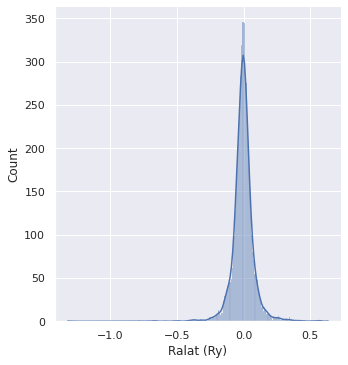

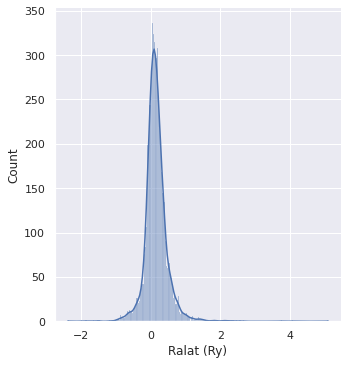

In [ ]:
g = sns.displot(y_test - y_pred_xgb, kde=True)
g.set_axis_labels('Ralat (Ry)')
g = sns.displot(y_test - coba, kde=True)
g.set_axis_labels('Ralat (Ry)')

In [ ]:
!pip3 install ann_visualizer
!pip install graphviz
!pip install h5py

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp36-none-any.whl size=4169 sha256=ff4a362ef3a075116a50888ec09e1c2a4da0e473e160e36a25b585ffecf0ffd0
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
